In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import optuna
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

SEED = 1234

# 1. Cargar y preparar el conjunto de datos
datos = pd.read_csv("Temp_Asu20092021.csv")
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
datos.set_index('Fecha', inplace=True)
datos = datos[datos.index.year >= 2019]
datos.dropna(inplace=True)

# 2. Calcular percentiles diarios (95, 50, 5)
percentiles_diarios = datos.resample('D')['Temperatura'].agg(
    Percentil_95=lambda x: np.percentile(x, 95),
    Mediana=lambda x: np.percentile(x, 50),
    Percentil_5=lambda x: np.percentile(x, 5)
)
# Crear la variable objetivo para el día siguiente
percentiles_diarios['Mediana_next'] = percentiles_diarios['Mediana'].shift(-1)
percentiles_diarios.dropna(inplace=True)

# 3. Dividir en entrenamiento y validación
split_date = "2021-01-01"
train = percentiles_diarios[:split_date]
valid = percentiles_diarios[split_date:]

# Definir X y y
y_train, y_valid = train['Mediana'], valid['Mediana']

# 4. Optimización con Optuna para SARIMAX
def objective_sarimax(trial):
    p = trial.suggest_int('p', 0, 3)
    d = trial.suggest_int('d', 0, 1)
    q = trial.suggest_int('q', 0, 3)
    P = trial.suggest_int('P', 0, 2)
    D = trial.suggest_int('D', 0, 1)
    Q = trial.suggest_int('Q', 0, 2)
    s = 7  # Estacionalidad semanal

    try:
        model = SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
        model_fit = model.fit(disp=False)
        y_pred = model_fit.forecast(steps=len(y_valid))
        mae = mean_absolute_error(y_valid, y_pred)
    except Exception:
        return float('inf')
    return mae

study_sarimax = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(seed=SEED))
study_sarimax.optimize(objective_sarimax, n_trials=10)

best_params_sarimax = study_sarimax.best_params
print("Mejores Hiperparámetros SARIMAX:", best_params_sarimax)

# 5. Entrenar y evaluar el modelo SARIMAX con los mejores parámetros
model_sarimax = SARIMAX(y_train, order=(best_params_sarimax['p'], best_params_sarimax['d'], best_params_sarimax['q']),
                        seasonal_order=(best_params_sarimax['P'], best_params_sarimax['D'], best_params_sarimax['Q'], 7))
model_fit_sarimax = model_sarimax.fit(disp=False)
y_pred_sarimax = model_fit_sarimax.forecast(steps=len(y_valid))
mae_sarimax = mean_absolute_error(y_valid, y_pred_sarimax)
print(f"MAE promedio SARIMAX en validación: {mae_sarimax}")


[I 2024-10-31 05:42:23,625] A new study created in memory with name: no-name-e80eda36-a25a-4247-9c67-75f4bcca221e
[I 2024-10-31 05:42:24,336] Trial 0 finished with value: 60.3974243729467 and parameters: {'p': 0, 'd': 1, 'q': 1, 'P': 2, 'D': 1, 'Q': 0}. Best is trial 0 with value: 60.3974243729467.
[I 2024-10-31 05:42:31,922] Trial 1 finished with value: 5.019947852257938 and parameters: {'p': 1, 'd': 1, 'q': 3, 'P': 2, 'D': 0, 'Q': 1}. Best is trial 1 with value: 5.019947852257938.
[I 2024-10-31 05:42:38,504] Trial 2 finished with value: 4.734045356202157 and parameters: {'p': 2, 'd': 1, 'q': 1, 'P': 1, 'D': 1, 'Q': 0}. Best is trial 2 with value: 4.734045356202157.
[I 2024-10-31 05:42:45,749] Trial 3 finished with value: 5.05283161176788 and parameters: {'p': 3, 'd': 1, 'q': 1, 'P': 1, 'D': 0, 'Q': 1}. Best is trial 2 with value: 4.734045356202157.
[I 2024-10-31 05:42:53,837] Trial 4 finished with value: 5.051454253717733 and parameters: {'p': 3, 'd': 1, 'q': 1, 'P': 2, 'D': 0, 'Q': 

Mejores Hiperparámetros SARIMAX: {'p': 0, 'd': 1, 'q': 1, 'P': 2, 'D': 0, 'Q': 0}
MAE promedio SARIMAX en validación: 4.336826691335936


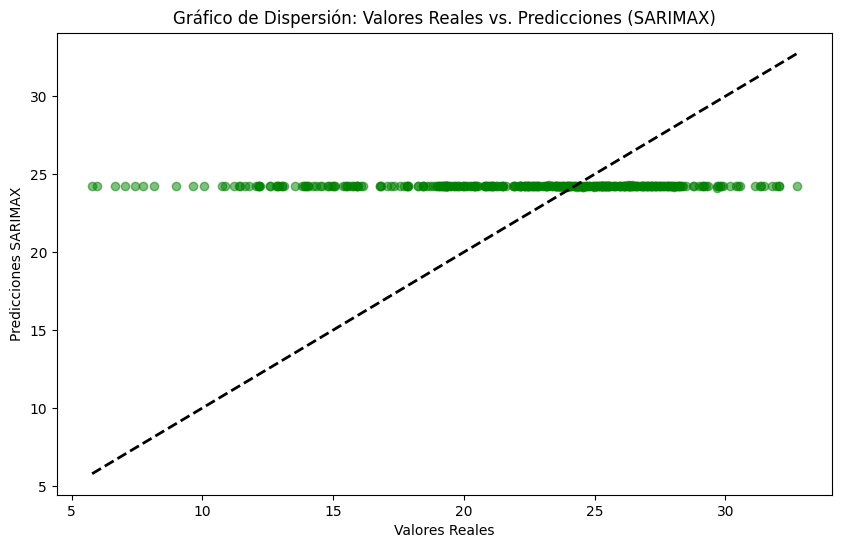

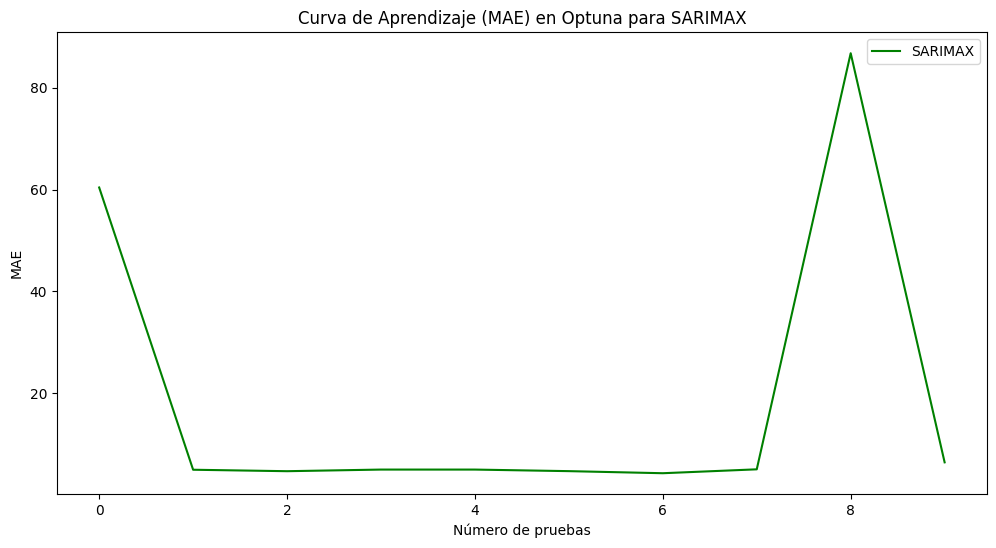

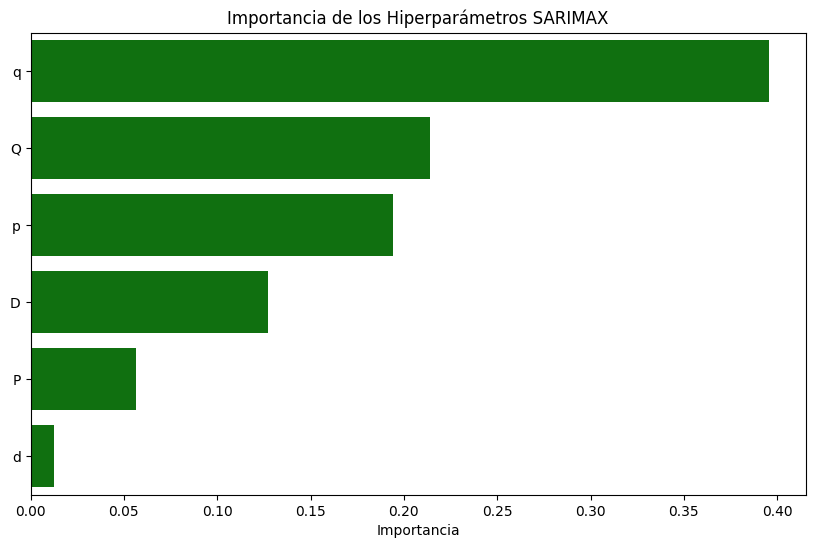

Top 10 resultados de SARIMAX en Optuna
   number      value  params_p  params_d  params_q  params_P  params_D  \
6       6   4.336827         0         1         1         2         0   
2       2   4.734045         2         1         1         1         1   
5       5   4.744637         3         0         3         0         1   
1       1   5.019948         1         1         3         2         0   
4       4   5.051454         3         1         1         2         0   
3       3   5.052832         3         1         1         1         0   
7       7   5.100862         0         1         2         1         0   
9       9   6.470681         2         1         3         2         1   
0       0  60.397424         0         1         1         2         1   
8       8  86.740596         1         1         0         1         1   

   params_Q  
6         0  
2         0  
5         2  
1         1  
4         1  
3         1  
7         1  
9         2  
0         0  
8     

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from optuna.importance import get_param_importances

# 1. Gráfico de Dispersión: Valores Reales vs. Predicciones (SARIMAX)
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred_sarimax, alpha=0.5, color='green')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones SARIMAX")
plt.title("Gráfico de Dispersión: Valores Reales vs. Predicciones (SARIMAX)")
plt.show()

# 2. Curva de Aprendizaje del modelo SARIMAX
sarimax_trials = study_sarimax.trials_dataframe()
plt.figure(figsize=(12, 6))
plt.plot(sarimax_trials['number'], sarimax_trials['value'], label='SARIMAX', color='green')
plt.xlabel("Número de pruebas")
plt.ylabel("MAE")
plt.title("Curva de Aprendizaje (MAE) en Optuna para SARIMAX")
plt.legend()
plt.show()

# 3. Importancia de los hiperparámetros SARIMAX
sarimax_importance = get_param_importances(study_sarimax)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(sarimax_importance.values()), y=list(sarimax_importance.keys()), color='green')
plt.title("Importancia de los Hiperparámetros SARIMAX")
plt.xlabel("Importancia")
plt.show()

# 4. Mostrar los 10 mejores resultados de Optuna para SARIMAX
top_10_sarimax = sarimax_trials.nsmallest(10, 'value')
print("Top 10 resultados de SARIMAX en Optuna")
print(top_10_sarimax[['number', 'value', 'params_p', 'params_d', 'params_q', 'params_P', 'params_D', 'params_Q']])
